In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.4 MB/s 
     |████████████████████████████████| 448 kB 42.7 MB/s 
     |████████████████████████████████| 86 kB 5.4 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import re
import urllib.request
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-dark")

from konlpy.tag import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## **DATASET 정리**

In [ ]:
def preprocess_df(train_data, test_data):

    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data.dropna(inplace=True)
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    train_data['document'] = train_data['document'].str.replace('^ +', "")   
    train_data['document'].replace("", np.nan, inplace=True)      
    train_data.dropna(inplace=True)
    train_data.drop_duplicates(subset=['document'], inplace=True)

    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.dropna(inplace=True)
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    test_data['document'] = test_data['document'].str.replace('^ +', "")   
    test_data['document'].replace("", np.nan, inplace=True)      
    test_data.dropna(inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)

    return train_data, test_data

### **Naver Movie Review Datset**

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt",\
                           filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt",\
                           filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f41000f26d0>)

In [ ]:
movie_test_data = pd.read_table("/content/ratings_test.txt")
movie_train_data = pd.read_table("/content/ratings_train.txt")

In [ ]:
movie_train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


### **Naver ShoppingMall Review Dataset**


In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", \
                    filename="shop_ratings.txt")

('shop_ratings.txt', <http.client.HTTPMessage at 0x7f410008d410>)

In [ ]:
shop_data = pd.read_table("/content/shop_ratings.txt")

In [ ]:
shop_data = shop_data.rename(columns={'5' : "label", "배공빠르고 굿" : "document"})
shop_data['label'] = shop_data['label'].apply(lambda x : 1 if x > 3 else 0)

In [ ]:
shop_data.shape

(199999, 2)

In [ ]:
shop_train_data = shop_data.iloc[:150000, :]
shop_test_data = shop_data.iloc[150000: :]

In [ ]:
shop_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   label     150000 non-null  int64 
 1   document  150000 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [ ]:
shop_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49999 entries, 150000 to 199998
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     49999 non-null  int64 
 1   document  49999 non-null  object
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [ ]:
shop_train_data.head(10)

,label,document
0,0,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
1,1,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
2,0,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
3,1,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ
4,0,비추합니다 계란 뒤집을 때 완전 불편해요 ㅠㅠ 코팅도 묻어나고 보기엔 예쁘고 실용적...
5,0,주문을 11월6에 시켰는데 11월16일에 배송이 왔네요 ㅎㅎㅎ 여기 회사측과는 전화...
6,0,넉넉한 길이로 주문했는데도 안 맞네요 별로예요
7,0,보폴이 계속 때처럼 나오다가 지금은 안나네요~
8,0,110인데 전문속옷브랜드 위생팬티105보다 작은듯해요. 불편해요. 밴딩부분이 다 신...
9,1,사이즈도 딱이고 귀엽고 넘 좋아요 ㅎㅎ


In [ ]:
shop_train_data['label'].value_counts()

0    75109
1    74891
Name: label, dtype: int64

In [ ]:
shop_test_data['label'].value_counts()

1    25071
0    24928
Name: label, dtype: int64

### **Game Review Dataset**

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", \
                           filename="game_ratings.txt")

('game_ratings.txt', <http.client.HTTPMessage at 0x7f41000aa3d0>)

In [ ]:
game_data = pd.read_table("/content/game_ratings.txt")

In [ ]:
game_data

,0,노래가 너무 적음
0,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
1,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
2,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
3,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요
4,1,역시 재미있네요 전작에서 할수 없었던 자유로운 덱 빌딩도 좋네요^^
...,...,...
99994,0,한글화해주면 10개산다
99995,0,개쌉노잼 ㅋㅋ
99996,0,노잼이네요... 30분하고 지웠어요...
99997,1,야생을 사랑하는 사람들을 위한 짧지만 여운이 남는 이야기. 영어는 그리 어렵지 않습니다.


In [ ]:
game_data = game_data.rename(columns={'0' : "label", '노래가 너무 적음' : "document"})

In [ ]:
game_train_data = game_data.iloc[:80000, :]
game_test_data = game_data.iloc[80000: :]

In [ ]:
game_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     80000 non-null  int64 
 1   document  80000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


In [ ]:
game_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 80000 to 99998
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     19999 non-null  int64 
 1   document  19999 non-null  object
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [ ]:
game_train_data['label'].value_counts()
game_test_data['label'].value_counts()

1    10003
0     9996
Name: label, dtype: int64

### **모든 데이터셋 preprocess 및 merge**

In [ ]:
movie_train_data, movie_test_data = preprocess_df(movie_train_data, movie_test_data)
shop_train_data, shop_test_data = preprocess_df(shop_train_data, shop_test_data)
game_train_data, game_test_data = preprocess_df(game_train_data, game_test_data)

In [ ]:
df_list = [movie_train_data, movie_test_data, shop_train_data, shop_test_data, game_train_data, game_test_data]

for df in df_list:
    print(df.shape)

(143620, 3)
(48389, 3)
(149638, 2)
(49936, 2)
(79517, 2)
(19970, 2)


In [ ]:
# column 순서 바꾸고 id column 삭제

movie_train_data.drop('id', axis=1, inplace=True)
movie_train_data = movie_train_data[['label', 'document']]
movie_test_data.drop('id', axis=1, inplace=True)
movie_test_data = movie_test_data[['label', 'document']]

In [ ]:
movie_train_data
movie_test_data

,label,document
0,1,굳 ㅋ
2,0,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아
3,0,지루하지는 않은데 완전 막장임 돈주고 보기에는
4,0,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠
5,1,음악이 주가 된 최고의 음악영화
...,...,...
49995,1,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함
49996,0,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따
49997,0,그림도 좋고 완성도도 높았지만 보는 내내 불안하게 만든다
49998,0,절대 봐서는 안 될 영화 재미도 없고 기분만 잡치고 한 세트장에서 다 해먹네


In [ ]:
# movie_train_data
# shop_train_data
game_train_data

,label,document
0,0,돌겠네 진짜 황숙아 어크 공장 그만 돌려라 죽는다
1,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
2,1,차악차악차악 정말 이래서 왕국을 되찾을 수 있는거야
3,1,시간 때우기에 좋음 도전과제는 시간이면 다 깰 수 있어요
4,1,역시 재미있네요 전작에서 할수 없었던 자유로운 덱 빌딩도 좋네요
...,...,...
79995,0,어느정도 재미가 있긴 하지만 지금 하기엔 너무 짜증나는 점이 많은 게임 돈모아서 다...
79996,1,평가 읽을 시간에 듀얼하셈 듀얼근 손실 옴 반박시 듀얼
79997,1,이후로는 게임이 상당히 변화했고 십자군 시스템과 혈통 시스템은 상당히 맘에 듭니다 ...
79998,1,냥겜


In [ ]:
# concat all three datasets

train_data = pd.concat([movie_train_data, shop_train_data, game_train_data], join='outer')
test_data = pd.concat([movie_test_data, shop_test_data, game_test_data], join='outer')

In [ ]:
train_data.shape
# test_data.shape

(372775, 2)

In [ ]:
train_data.head(10)

,label,document
0,0,아 더빙 진짜 짜증나네요 목소리
1,1,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
2,0,너무재밓었다그래서보는것을추천한다
3,0,교도소 이야기구먼 솔직히 재미는 없다평점 조정
4,1,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...
5,0,막 걸음마 뗀 세부터 초등학교 학년생인 살용영화ㅋㅋㅋ별반개도 아까움
6,0,원작의 긴장감을 제대로 살려내지못했다
7,0,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지정말 발로해도 그것보단 낫...
8,1,액션이 없는데도 재미 있는 몇안되는 영화
9,1,왜케 평점이 낮은건데 꽤 볼만한데 헐리우드식 화려함에만 너무 길들여져 있나


---

## **Tokenization & Padding**

In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
stopwords += ['이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '않', '없', '나', '사람', '주', '아니', '등', '같', '우리', '때', '년', '가', '한', '지', '대하', '오', '말', '일', '그렇', '위하']
stopwords = list(set(stopwords))
# stopwords

In [ ]:
from konlpy.tag import Okt      
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

okt = Okt()

In [ ]:
x_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sent = okt.morphs(sentence, stem=True)      # 형태소 별로 문장 분할
    tokenized_sent = [word for word in tokenized_sent if word not in stopwords]   # 불용어 제거
    x_train.append(tokenized_sent)

100%|██████████| 372775/372775 [24:49<00:00, 250.33it/s]


In [ ]:
x_train[:2]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다']]

In [ ]:
x_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sent = okt.morphs(sentence, stem=True)      # 형태소 별로 문장 분할
    tokenized_sent = [word for word in tokenized_sent if word not in stopwords]   # 불용어 제거
    x_test.append(tokenized_sent)

100%|██████████| 118295/118295 [09:59<00:00, 197.30it/s]


In [ ]:
test_data['document'][:2]
x_test[:2]

[['굳다', 'ㅋ'], ['뭐', '야', '평점', '나쁘다', '않다', '점', '짜다', '리', '더', '더욱', '아니다']]

In [ ]:
x_train_raw = x_train
x_test_raw = x_test

#### **Tokenizer 로 단어사전 만들기 & 정수 Encoding**
- 단어사전은 train_data 로 만들어야 함

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)  

tokenizer.word_index      # 빈도수가 높은 단어별로 작은 수의 양의 정수를 부여함
len(tokenizer.word_index)

75147

In [ ]:
threshold = 4
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0      
total_freq = 0     
rare_freq = 0       

for key, value in tokenizer.word_counts.items():
    total_freq += value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 75147
등장 빈도가 3번 이하인 희귀 단어의 수: 48485
단어 집합에서 희귀 단어의 비율: 64.52020706082745
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.5172733686959021


In [ ]:
vocab_size = total_cnt - rare_cnt + 1
vocab_size

26663

In [ ]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(x_train)   # 0번 단어 ~ 19395번 단어까지만 사용

In [ ]:
# Referring to word_index, text --> numeric sequences  

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [ ]:
print(x_train[:3])
print(x_test[:3])

[[64, 1007, 30, 364, 1329], [897, 1127, 69, 1146, 4, 236, 1843, 99, 1259, 328, 15], [354, 4758, 3973, 4417, 1, 83, 12]]
[[668, 160], [86, 246, 101, 375, 15, 53, 254, 770, 34, 1074, 20], [151, 15, 117, 861, 140, 102, 68, 315, 176]]


In [ ]:
len(x_test)
# len(x_test)

118295

In [ ]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [ ]:
# Remove empty sequence in x_train, which means those seq are composed of only the words that are under set threshold

drop_target = [idx for idx, sentence in enumerate(x_train) if len(sentence) < 1]
x_train = np.delete(x_train, drop_target, axis=0)       # np.delete(array, delete_target_idx, axis=0(row) or 1(col))
y_train = np.delete(y_train, drop_target, axis=0)

In [ ]:
print(len(x_train))
print(len(y_train))       # 143620 --> 143376

372193
372193


### **Padding**
- 모델이 처리할 수 있도록 X_train과 X_test의 모든 샘플의 길이를 특정 길이로 동일하게 맞춤
- padding_len 

리뷰의 최대 길이 : 68
리뷰의 평균 길이 : 11.614372113392783


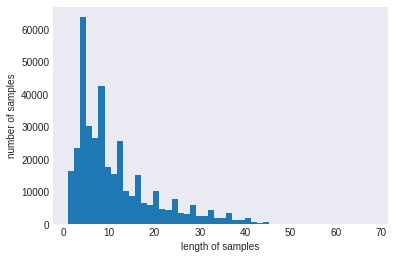

In [ ]:
print('리뷰의 최대 길이 :', max(map(len, x_train)))
print('리뷰의 평균 길이 :',sum(map(len, x_train))/len(x_train))
plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def find_padding_len(set_len):
    cnt = 0
    for l in list(map(len, x_train)):
        if l <= set_len:
            cnt += 1
    return (cnt/len(x_train))*100

for set_len in range(10, 50, 5):
    tmp = find_padding_len(set_len)
    print("길이 {0} : {1}%".format(set_len, tmp))

길이 10 : 59.378870639694995%
길이 15 : 75.60620430798%
길이 20 : 84.42609076473765%
길이 25 : 90.24833889944196%
길이 30 : 94.36824443232409%
길이 35 : 97.26539725357543%
길이 40 : 99.18187606967352%
길이 45 : 99.86969126232896%


In [ ]:
padding_len = 35

In [ ]:
x_train = pad_sequences(x_train, maxlen = padding_len, truncating='post', padding='post')
x_test = pad_sequences(x_test, maxlen = padding_len, truncating='post', padding='post')

In [ ]:
x_train

array([[   64,  1007,    30, ...,     0,     0,     0],
       [  897,  1127,    69, ...,     0,     0,     0],
       [  354,  4758,  3973, ...,     0,     0,     0],
       ...,
       [  470,   824,    51, ...,     0,     0,     0],
       [  688,  1106,     8, ...,     0,     0,     0],
       [19611,  5647,  2779, ...,     0,     0,     0]], dtype=int32)

In [ ]:
x_train.shape       # padding 완료

(372193, 35)

---

## **LSTM Training with DATASET** 

#### **Import Modules**

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
emb_dim = 100
cur_dim = 26663     # vocab size
padding_len = 35

In [ ]:
model = Sequential([
    Embedding(cur_dim, emb_dim, input_length=padding_len),      
    Bidirectional(LSTM(128, return_sequences=True)),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 35, 100)           2666300   
                                                                 
 bidirectional_1 (Bidirectio  (None, 35, 256)          234496    
 nal)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 32)                36992     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,937,821
Trainable params: 2,937,821
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
checkpoint_path = 'my_checkpoint.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

In [ ]:
earlystop = EarlyStopping(monitor="val_loss", 
                          min_delta=0.001,        
                          patience=2)

In [ ]:
epochs=10
history = model.fit(x_train, y_train, 
                    validation_data=(x_test, y_test),
                    callbacks=[checkpoint, earlystop],
                    epochs=epochs)

Epoch 1/10
11631/11632 [============================>.] - ETA: 0s - loss: 0.3492 - acc: 0.8493
Epoch 00001: val_loss improved from inf to 0.33655, saving model to my_checkpoint.ckpt
11632/11632 [==============================] - 428s 37ms/step - loss: 0.3492 - acc: 0.8493 - val_loss: 0.3366 - val_acc: 0.8570
Epoch 2/10
11632/11632 [==============================] - ETA: 0s - loss: 0.2986 - acc: 0.8740
Epoch 00002: val_loss improved from 0.33655 to 0.32506, saving model to my_checkpoint.ckpt
11632/11632 [==============================] - 429s 37ms/step - loss: 0.2986 - acc: 0.8740 - val_loss: 0.3251 - val_acc: 0.8614
Epoch 3/10
11632/11632 [==============================] - ETA: 0s - loss: 0.2634 - acc: 0.8908
Epoch 00003: val_loss did not improve from 0.32506
11632/11632 [==============================] - 429s 37ms/step - loss: 0.2634 - acc: 0.8908 - val_loss: 0.3457 - val_acc: 0.8606


In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
loss, acc = model.evaluate(x_test, y_test)

3697/3697 [==============================] - 57s 13ms/step - loss: 0.3251 - acc: 0.8614


In [ ]:
model.save_weights('lstm_model.h5')

In [ ]:
model.save("model")

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


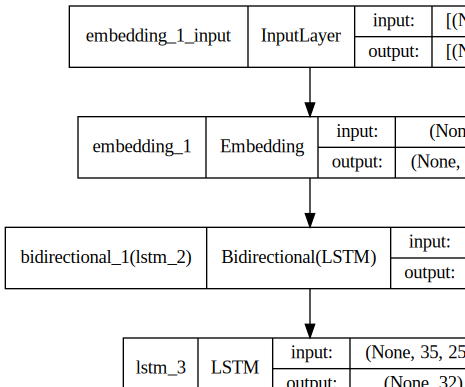

In [ ]:
import pydot
import graphviz
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
print("Model Loss : {0}\nModel Accuracy : {1}".format(np.round(loss, 4), np.round(acc, 4)))

Model Loss : 0.3251
Model Accuracy : 0.8614


---

## **Sentiment Analysis of Covid19 Related SNS Postings from NAVER, Twitter**

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [ ]:
naver_emo = pd.read_excel("/content/NAVER_코로나, 감정.xlsx")
naver_mood = pd.read_excel("/content/NAVER_코로나, 기분.xlsx")
naver_daily = pd.read_excel("/content/NAVER_코로나, 일상.xlsx")

twitter_emo = pd.read_excel("/content/Tweets_코로나, 감정.xlsx")
twitter_mood = pd.read_excel("/content/Tweets_코로나, 기분.xlsx")
twitter_daily = pd.read_excel("/content/Tweets_코로나, 일상.xlsx")

In [ ]:
naver_emo.rename(columns={'Tweets' : 'Contents'}, inplace=True)
naver_mood.rename(columns={'Tweets' : 'Contents'}, inplace=True)
naver_daily.rename(columns={'Tweets' : 'Contents'}, inplace=True)
twitter_emo.rename(columns={'Tweets' : 'Contents'}, inplace=True)
twitter_mood.rename(columns={'Tweets' : 'Contents'}, inplace=True)
twitter_daily.rename(columns={'Tweets' : 'Contents'}, inplace=True)

In [ ]:
naver_emo['Positive'] = 0
naver_emo['Negative'] = 0

naver_mood['Positive'] = 0
naver_mood['Negative'] = 0

naver_daily['Positive'] = 0
naver_daily['Negative'] = 0

twitter_emo['Positive'] = 0
twitter_emo['Negative'] = 0

twitter_mood['Positive'] = 0
twitter_mood['Negative'] = 0

twitter_daily['Positive'] = 0
twitter_daily['Negative'] = 0

NameError: ignored

In [ ]:
naver_emo

,Date,Weekly Frequency,Contents,Positive,Negative
0,20200101,146,"['년 월 일 비대면온라인개강성경적감정코칭총신대학교평생교육원 전문교육아카데미', '...",0,0
1,20200107,166,"['스스로 변화를 이끌어내는 셀프코칭 일 감정일기 프로젝트 기 모집 일정 연기', ...",0,0
2,20200114,164,['왜 나는 항상 먹고나서 후회할까 원데이클래쓰 차 오픈 코로나 사태로 잠정 보류'...,0,0
3,20200121,890,"[' 우한 발생 신종 코로나 바이러스 폐렴 질환 확산과 주식 시장', '신종코로나바...",0,0
4,20200201,896,"[' 감정일기 코로나 바이러스', ' 미국 증시의 이격 조정 그리고 신종 코로나 ...",0,0
...,...,...,...,...,...
83,20210921,896,"[' 위드코로나 길어질수록 내 감정을 해치는 영향들', '생장일지 감정을 기록하는 ...",0,0
84,20211001,880,['앵콜전시 화무십일홍 전시 코로나 블루시대 인 작가의 감정과 사유 아트포스터 전...,0,0
85,20211007,898,['앵콜전시 화무십일홍 전시 코로나 블루시대 인 작가의 감정과 사유 아트포스터 전...,0,0
86,20211014,894,"['일본인 중국 싫다코로나 속 국민감정 역대 최악', '일본인 중국 싫다코로나...",0,0


In [ ]:
def get_sentiment(sen):
    sen = okt.morphs(sen, stem=True)
    sen = [word for word in sen if word not in stopwords]
    encoded = tokenizer.texts_to_sequences([sen])       # label encoding
    padded = pad_sequences(encoded, maxlen=padding_len)       # padding
    # print(padded)
    score = float(model.predict(padded))
    if score >= 0.65:
        return 1
    else:
        return -1

In [ ]:
pos_sen = []
neg_sen = []

In [ ]:
def measure_sentiment_for_each_df(df):
    for i, contents in tqdm(enumerate(df['Contents'])):
        content_list = contents.split(',')

        for sen in content_list:
            sen = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", sen)
            tmp_res = get_sentiment(sen)
            if tmp_res == 1:
                df['Positive'][i] += 1
                pos_sen.append(sen)
            else:
                df['Negative'][i] += 1
                neg_sen.append(sen)

In [ ]:
pd.options.mode.chained_assignment = None

In [ ]:
df_list = [twitter_mood, twitter_daily]
df_name_list = ["twitter_mood", "twitter_daily"]
# f"{df_name_list[3]}"

In [ ]:
i = 0
for df in tqdm(df_list):
    measure_sentiment_for_each_df(df)
    df.to_excel(f"{df_name_list[i]}.xlsx")
    keywords = {'pos' : [pos_sen], 'neg': [neg_sen]}
    keywords_df = pd.DataFrame(keywords)
    keywords_df.to_excel("categorized_keywords.xlsx")
    i += 1

  0%|          | 0/2 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.30s/it]
3it [00:01,  2.60it/s]
4it [00:03,  1.16it/s]
5it [00:12,  3.78s/it]
6it [00:21,  5.31s/it]
7it [00:33,  7.36s/it]
8it [01:01, 13.89s/it]
9it [01:31, 18.66s/it]
10it [01:59, 21.54s/it]
11it [02:26, 23.26s/it]
12it [02:53, 24.31s/it]
13it [03:14, 23.56s/it]
14it [03:36, 23.08s/it]
15it [03:54, 21.41s/it]
16it [04:11, 20.03s/it]
17it [04:21, 17.03s/it]
18it [04:39, 17.24s/it]
19it [04:52, 16.00s/it]
20it [05:08, 16.17s/it]
21it [05:17, 14.08s/it]
22it [05:29, 13.37s/it]
23it [05:38, 12.14s/it]
24it [05:47, 11.10s/it]
25it [05:55, 10.01s/it]
26it [06:02,  9.13s/it]
27it [06:08,  8.37s/it]
28it [06:14,  7.62s/it]
29it [06:19,  6.78s/it]
30it [06:25,  6.57s/it]
31it [06:48, 11.43s/it]
32it [07:15, 16.07s/it]
33it [07:31, 16.04s/it]
34it [07:46, 15.73s/it]
35it [07:57, 14.47s/it]
36it [08:08, 13.33s/it]
37it [08:15, 11.53s/it]
38it [08:24, 10.64s/it]
39it [08:30,  9.43s/it]
40it [08:37,  8.52s/it]
41it [08:42,  7

In [ ]:
naver_emo
# naver_mood
# naver_daily

# twitter_emo
# twitter_mood
twitter_daily.to_excel("twitter_daily_2.xlsx")

In [ ]:
from tensorflow.python.keras.models import load_model

model.load_weights('/content/lstm_model.h5')